I en ny fil importerer du Keras, og initierer en modell for å jobbe med:

In [15]:
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.metrics import classification_report

model = models.Sequential()


Deretter konfigurerer man lagene i nettverket:

In [3]:
# 32 filters with 3x3 pixel kernels and ReLU activation for 150x150 RGB (= 3-channel) images
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))

# Downsample by picking max input from every 2x2 window of previous neurons
model.add(layers.MaxPooling2D((2, 2))) 

# Next layer of filters
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# More downsampling (important to reduce network size/complexity)
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))

Legg merke til mønstret her:

"Conv2D" lag (som brukes fordi datasettet er bilder der konvolusjonen gjøres i 2 dimensjoner)
et "MaxPooling2D" lag
et nytt Conv2D-lag
et MaxPooling2D lag ... osv.
Dette er en klassisk struktur for et convnet. Hvert lag bygges på modellen med model.add()-funksjonen. Output fra et lag blir automatisk input til neste lag som legges til modellen. Merk at man når som helst kan inspisere modellen underveis med "model.summary()".

Til sist ønsker vi å kombinere alle verdiene ned til én verdi som avgjør hvilket bilde vi har med å gjøre: Hund eller katt? Kombineringen gjør vi ved å først flate ut (Flatten) output fra tidligere lag til én lang vektor og koble hver av disse (Dense = koble til alle output fra forrige lag) til et lag med 512 nevroner, deretter ved å ha ett siste nevron koblet til alle disse 512. Dette ene nevronet er det som til slutt forteller oss hvilken kategori nettverket har konkludert med:

In [4]:
model.add(layers.Flatten()) 
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))

Legg merke til at aktiveringsfunksjonen til de fleste lagene er ReLU (Lenker til en ekstern side.), men det siste nevronet benytter sigmoid (Lenker til en ekstern side.), som vi har nevnt litt tidligere. Sigmoid-funksjonen gir en output mellom 0 (katt) og 1 (hund), og funksjonen er veldig sikker (lav endringsrate) i klassifiseringen når den er nært 0 eller 1, men indikerer veldig usikker klassifisering (høy endringsrate) rundt midten (0,5). Bruk av sigmoid i siste lag av CNN er forøvrig veldig utbredt.

Det siste vi gjør før vi kan begynne å trene modellen er å angi hvilken "loss"-funksjon vi ønsker å benytte - altså hvordan vi måler "hvor feil" en gjetting er under trening. I vårt tilfelle er binær kryssentropi (Lenker til en ekstern side.) godt egnet til å gjøre denne tallfestingen av hvor godt nettverkets "gjetting" stemmer med "fasit". De øvrige parametrene er optimering ved bruk av Root Mean Square (Lenker til en ekstern side.): RMSprop(lr=1e-4), hvor lr er en læringsrate som angir hvor mye nettverket skal endres per iterasjon, og "metrics" som "acc" (accuracy) som sier at vi ønsker å rapportere hvor nøyaktig modellen treffer på klassifisering (kun rapportere, denne har ingen betydning for læring):

In [5]:
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

/home/ndiseza/.conda/envs/ml/lib/python3.9/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Trening
Selve treningen av nettet krever litt av maskinvaren... husk god kjøling, og vær særlig varsom om du bruker laptop. Vi bruker ferdig bibliotek for å lese inn og skalere bildene i batch:



In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = "./datasett/small/train"
validation_dir = "./datasett/small/val"

im_per_batch = 20 
im_size = (150,150) # Same as number of inputs in the network

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=im_size,
    batch_size=im_per_batch,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=im_size,
    batch_size=im_per_batch,
    class_mode='binary')

Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Når du nå til slutt starter selve treningen kan du forvente en ganske lang periode (minutter eller dager) med tallknusing og dertilhørende viftestøy og varmeutvikling:

In [11]:
num_epochs = 30
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n // im_per_batch,
    epochs=num_epochs,
    validation_data = validation_generator,
    validation_steps = validation_generator.n // im_per_batch)

Epoch 1/30
200/200 [==============================] - 52s 260ms/step - loss: 0.4788 - acc: 0.7745 - val_loss: 0.5275 - val_acc: 0.7320
Epoch 2/30
200/200 [==============================] - 53s 263ms/step - loss: 0.4471 - acc: 0.7903 - val_loss: 0.4750 - val_acc: 0.7590
Epoch 3/30
200/200 [==============================] - 52s 259ms/step - loss: 0.4267 - acc: 0.8065 - val_loss: 0.4818 - val_acc: 0.7710
Epoch 4/30
200/200 [==============================] - 53s 266ms/step - loss: 0.3966 - acc: 0.8253 - val_loss: 0.5504 - val_acc: 0.7400
Epoch 5/30
200/200 [==============================] - 52s 260ms/step - loss: 0.3737 - acc: 0.8363 - val_loss: 0.4434 - val_acc: 0.7890
Epoch 6/30
200/200 [==============================] - 52s 259ms/step - loss: 0.3576 - acc: 0.8460 - val_loss: 0.4819 - val_acc: 0.7730
Epoch 7/30
200/200 [==============================] - 53s 264ms/step - loss: 0.3296 - acc: 0.8555 - val_loss: 0.4328 - val_acc: 0.7960
Epoch 8/30
200/200 [==============================] - 5

Tips: Ettersom treningen tar lang tid, kan det være greit å lagre det ferdigtrente nettet. Du kan lagre og hente tilbake den ferdig trente modellen med:

In [12]:
model.save('model/dogs-vs-cats-1.h5')
from keras.models import load_model

In [17]:
model = load_model('model/dogs-vs-cats-1.h5')

Fungerer da nettet til klassifisering? Test med 5 bilder av hunder og 5 bilder av katter. Pass på at du bruker nye bilder som maskinen ikke har sett under trening - gjerne egne fotografier:

In [ ]:
test_image_path = "./datasett/test/image1.jpg"

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy
import matplotlib.pyplot as plt

img = load_img(test_image_path,target_size = (150,150)) # Load image and adjust to 150x150
img = img_to_array(img)/255 # Image to 3D array
img = numpy.expand_dims(img,axis=0) # Network expects a "batch" -> Create a single image batch
plt.imshow(img[0])

# Test prediction
y = model.predict(img)[0][0]
if y > 0.5:     # Most probably a dog
    print('With a probability of ' + str(y*100) + '%, this is a dog.')
else:           # Most probably a cat
    print('With a probability of ' + str((1-y)*100) + '%, this is a cat.')

report = classification_report(model, y)

Vurdering av modellen
Til slutt skal vi se på hvordan vi kan visualisere effekten av treningen. Trener vi nettverket nok, for lite eller kanskje overdrevent mye? Nettverket bør testes både på trenings og valideringsdata. Husk at valideringsdata er data som nettverket aldri "ser" under trening. Det kan således være interessant å sammenligne hvor godt nettverket treffer på treningsdata versus valideringsdata. Noen ganger kan treningen faktisk føre til at nettverket lærer seg spesifikke egenskaper ved treningsdataene så godt at det blir gradvis dårligere til å kategorisere valideringsdata - såkalt "overfitting". Vi kan visualisere kvaliteten for hver type data per treningsepoke med matplotlib:

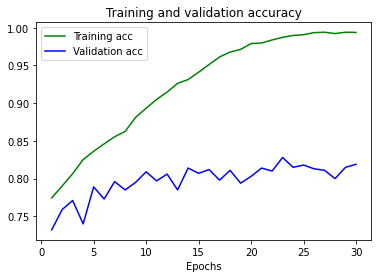

In [30]:
hist = history.history  # Get dictionary with logged accuracies and losses
epochs = list(range(1,num_epochs+1))    # Get list of epoch numbers

import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(epochs, hist['acc'], 'g', label='Training acc')
plt.plot(epochs, hist['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend()

With a probability of 99.8601645231247%, this is a cat.
With a probability of 99.91813004016876%, this is a cat.
With a probability of 99.99921317439657%, this is a cat.
With a probability of 99.99617338180542%, this is a dog.
With a probability of 99.96733069419861%, this is a cat.
With a probability of 61.38044595718384%, this is a dog.
With a probability of 99.97375011444092%, this is a dog.
With a probability of 91.65850877761841%, this is a dog.
With a probability of 97.59433567523956%, this is a cat.
With a probability of 99.46895837783813%, this is a dog.


<Figure size 2160x2160 with 0 Axes>

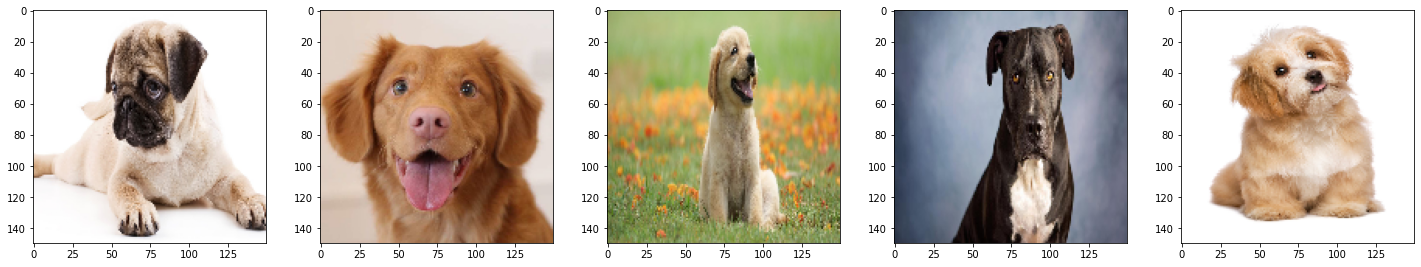

In [67]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy
import matplotlib.pyplot as plt
array_images = []
for animal in ['cat','dog']:
    test_image_folder = "./test_images/{}".format(animal)

    
    plt.figure(figsize=(30,30))
    for pic in os.listdir(test_image_folder):
        pic_path = os.path.join(test_image_folder, pic)
        img = load_img(pic_path,target_size = (150,150)) # Load image and adjust to 150x150
        img = img_to_array(img)/255 # Image to 3D array
        img = numpy.expand_dims(img,axis=0) # Network expects a "batch" -> Create a single image batch

        array_images.append(img[0])
        # Test prediction
        y = model.predict(img)[0][0]
        if y > 0.5:     # Most probably a dog
            print('With a probability of ' + str(y*100) + '%, this is a dog.')
        else:           # Most probably a cat
            print('With a probability of ' + str((1-y)*100) + '%, this is a cat.')

for i in range(len(array_images)):
    curr = array_images[i]
    plt.subplot(6, 6, (i+1))
    plt.imshow(curr, cmap=plt.cm.binary)
    